# Trabajo Practico 5: Restauracion de Imagenes

In [10]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.restoration import richardson_lucy
from skimage.metrics import mean_squared_error

img = cv2.imread("clown.jpg", cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float32) / 255.0  # normalize to [0,1]

In [2]:
def mse(original, restored):
    return np.mean((original - restored) ** 2)

## Ejercicio 1

Inverse Filtering 
- Blur 
- Blur + Noise

In [5]:
def motion_blur_kernel(size=15):
    kernel = np.zeros((size, size))
    kernel[size // 2, :] = np.ones(size)
    kernel /= size
    return kernel

def blur_image(img, psf):
    img_fft = np.fft.fft2(img)
    psf_padded = np.zeros_like(img)
    psf_padded[:psf.shape[0], :psf.shape[1]] = psf
    psf_fft = np.fft.fft2(psf_padded)
    blurred = np.fft.ifft2(img_fft * psf_fft)
    return np.abs(blurred), psf_fft

def inverse_filter(blurred, psf_fft, eps=1e-3):
    blurred_fft = np.fft.fft2(blurred)
    psf_fft_safe = psf_fft.copy()
    psf_fft_safe[np.abs(psf_fft_safe) < eps] = eps  
    restored_fft = blurred_fft / psf_fft_safe
    restored = np.fft.ifft2(restored_fft)
    return np.abs(restored)

MSE (blur only): 0.000004
MSE (blur + noise): 0.707490


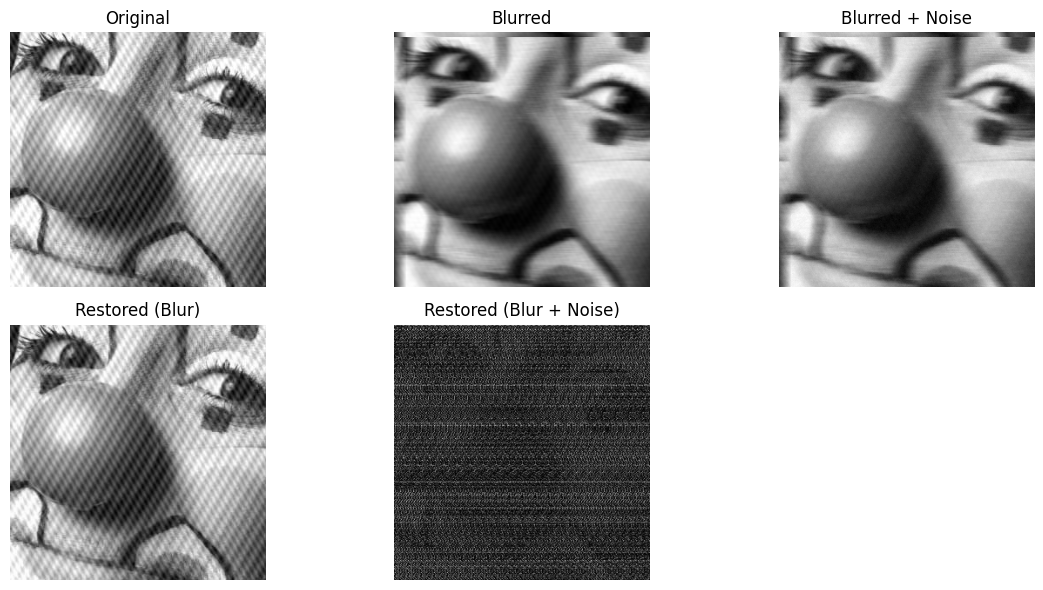

In [6]:
psf = motion_blur_kernel(15)

blurred, psf_fft = blur_image(img, psf)

noise = np.random.normal(0, 0.01, img.shape)
blurred_noisy = np.clip(blurred + noise, 0, 1)

restored_blur = inverse_filter(blurred, psf_fft)
restored_blur_noise = inverse_filter(blurred_noisy, psf_fft)

mse_blur = mse(img, restored_blur)
mse_blur_noise = mse(img, restored_blur_noise)

print(f"MSE (blur only): {mse_blur:.6f}")
print(f"MSE (blur + noise): {mse_blur_noise:.6f}")

titles = ['Original', 'Blurred', 'Blurred + Noise', 'Restored (Blur)', 'Restored (Blur + Noise)']
images = [img, blurred, blurred_noisy, restored_blur, restored_blur_noise]

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Ejercicio 2

Wiener: Blur + Noise

MSE (Inverse, Blur + Noise): 0.664643
MSE (Wiener, Blur + Noise): 0.004359


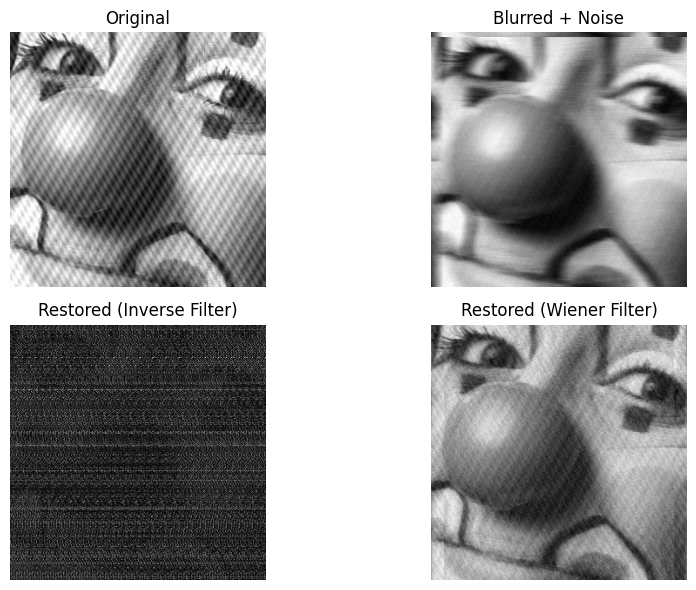

In [7]:
def wiener_filter(blurred, psf_fft, K=0.01):
    blurred_fft = np.fft.fft2(blurred)
    psf_conj = np.conj(psf_fft)
    psf_abs2 = np.abs(psf_fft) ** 2
    restored_fft = (psf_conj / (psf_abs2 + K)) * blurred_fft
    restored = np.fft.ifft2(restored_fft)
    return np.abs(restored)

psf = motion_blur_kernel(15)
blurred, psf_fft = blur_image(img, psf)
noise = np.random.normal(0, 0.01, img.shape)
blurred_noisy = np.clip(blurred + noise, 0, 1)

restored_inverse = inverse_filter(blurred_noisy, psf_fft)
restored_wiener = wiener_filter(blurred_noisy, psf_fft, K=0.01)

mse_inv = mse(img, restored_inverse)
mse_wiener = mse(img, restored_wiener)
print(f"MSE (Inverse, Blur + Noise): {mse_inv:.6f}")
print(f"MSE (Wiener, Blur + Noise): {mse_wiener:.6f}")

titles = [
    'Original', 'Blurred + Noise',
    'Restored (Inverse Filter)', 'Restored (Wiener Filter)'
]
images = [img, blurred_noisy, restored_inverse, restored_wiener]

plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


## Ejercicio 3

Blind Deconvolution

MSE (Blurred+Noise vs Original): 0.029466
MSE (Restored vs Original):     0.055494


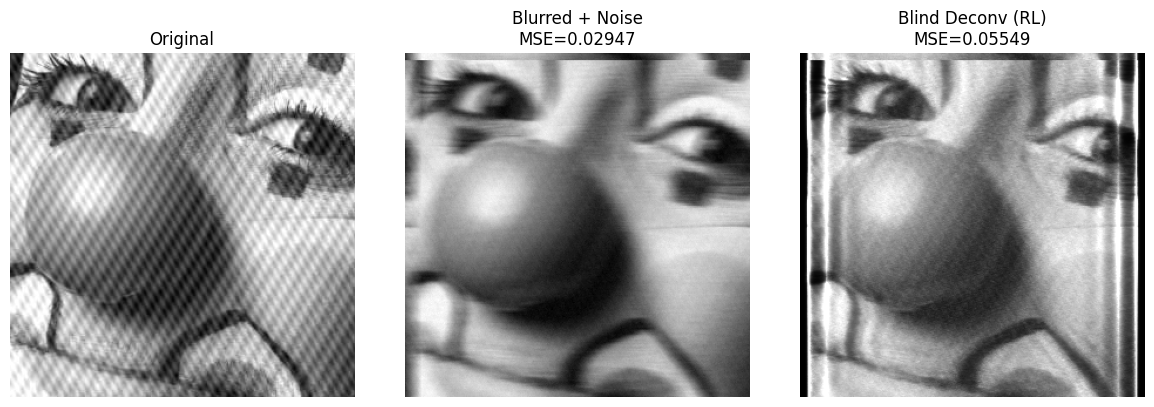

In [ ]:

def blind_deconvolution(blurred, psf, iterations=30):
    deconv = richardson_lucy(blurred, psf, num_iter=iterations, clip=True)
    return deconv

psf = motion_blur_kernel(15)
blurred, psf_fft = blur_image(img, psf)
noise = np.random.normal(0, 0.01, img.shape)
blurred_noisy = np.clip(blurred + noise, 0, 1)


restored = blind_deconvolution(blurred_noisy, psf, iterations=30)

mse_blurred = mean_squared_error(img, blurred_noisy)
mse_restored = mean_squared_error(img, restored)

print(f"MSE (Blurred+Noise vs Original): {mse_blurred:.6f}")
print(f"MSE (Restored vs Original):     {mse_restored:.6f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(blurred_noisy, cmap='gray')
plt.title(f"Blurred + Noise\nMSE={mse_blurred:.5f}")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(restored, cmap='gray')
plt.title(f"Blind Deconv (RL)\nMSE={mse_restored:.5f}")
plt.axis('off')

plt.tight_layout()
plt.show()


## Ejercicio 4

Motion Blur

Mean Squared Error (MSE): 0.01


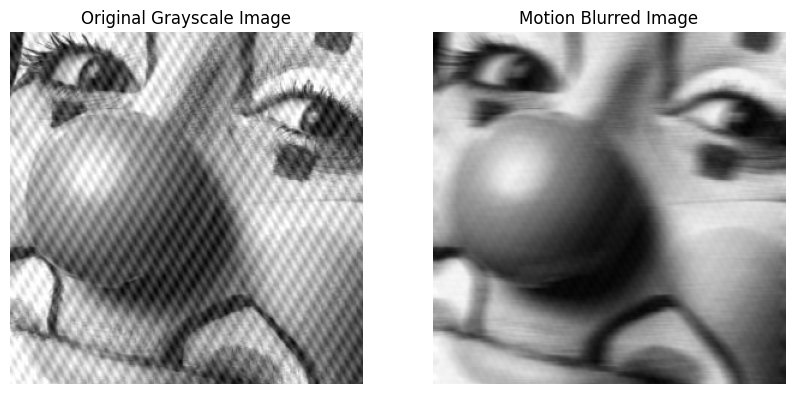

In [22]:
kernel_size = 15
motion_blur_kernel = np.zeros((kernel_size, kernel_size))
motion_blur_kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size)
motion_blur_kernel = motion_blur_kernel / kernel_size

blurred_img = cv2.filter2D(img, -1, motion_blur_kernel)

mse_value = mse(img, blurred_img)

print(f"Mean Squared Error (MSE): {mse_value:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Grayscale Image')
axes[0].axis('off') 

axes[1].imshow(blurred_img, cmap='gray')
axes[1].set_title('Motion Blurred Image')
axes[1].axis('off')

plt.show()